# This stuff is the by the book implementation

In [33]:
import numpy as np
import itertools
import math

In [34]:
np.set_printoptions(linewidth=200)

In [35]:
def combs_with_multiplicity_recip(vals, n):
    if n == 0:
        yield (1, [])
    elif len(vals) == 1:
        yield (math.factorial(n), [vals[0]] * n)
    else:
        for i in range(0, n+1):
            for (rest_recip, rest_vals) in combs_with_multiplicity_recip(vals[1:], n-i):
                yield (rest_recip * math.factorial(i), [vals[0]] * i + rest_vals)

In [36]:
def combs_with_multiplicity(vals, n):
    fact = math.factorial(n)
    for recip, vals in combs_with_multiplicity_recip(vals, n):
        yield fact // recip, vals

In [62]:
def multiplicity_space_combs(m, n):
    if n == 0:
        yield (0,) * m
    elif m == 1:
        yield (n,)
    else:
        for i in range(0, n+1):
            for rest_vals in multiplicity_space_combs(m-1, n-i):
                yield (i,) + rest_vals

In [71]:
def replace(tup, idx, val):
    return tup[:idx] + (val,) + tup[idx+1:]

In [80]:
def rot(tup, r):
    return tup[r:] + tup[:r]

In [110]:
def finish_vec(vec, index, n_left, in_limit):    
    if n_left == 0:
        yield vec
        return

    if index >= len(vec):
        return
    
    max_val = min(vec[in_limit], n_left)
    if index == len(vec) - 1 and in_limit != len(vec) - 2:
        max_val = min(max_val, vec[0] - 1)

    for res in finish_vec(replace(vec, index, max_val), index+1, n_left - max_val, in_limit+1 if max_val == vec[in_limit] else in_limit):
        yield res

    for i in range(max_val-1, -1, -1):
        for res in finish_vec(replace(vec, index, i), index+1, n_left - i, 0):
            yield res

In [111]:
def multiplicity_space_necklaces(m, n):
    for i in range(n, 0, -1):
        for res in finish_vec((i,) + (0,) * (m-1), 1, n-i, 0):
            yield res

In [118]:
def check_no_dups(necklaces, m):
    stuff = set(necklaces)
    for i in range(1, m):
        for nl in necklaces:
            rot_val = rot(nl, i)
            if rot_val in stuff:
                assert rot_val == nl, f"{rot_val} is in stuff and so is {nl}"

In [119]:
def get_all_rotations(necklaces, m):
    stuff = set(necklaces)
    for i in range(1, m):
        for nl in necklaces:
            rot_val = rot(nl, i)
            stuff.add(rot_val)

    return stuff

In [120]:
def test_case(m, n):
    necklaces = list(multiplicity_space_necklaces(m, n))
    check_no_dups(necklaces, m)
    assert get_all_rotations(necklaces, m) == set(multiplicity_space_combs(m, n))

In [121]:
test_case(7, 9)

AssertionError: (4, 0, 1, 0, 0, 4, 0) is in stuff and so is (4, 0, 4, 0, 1, 0, 0)

In [75]:
[x for x in multiplicity_space_necklaces(3, 9)]

[(9, 0, 0),
 (8, 1, 0),
 (8, 0, 1),
 (7, 2, 0),
 (7, 1, 1),
 (7, 0, 2),
 (6, 3, 0),
 (6, 2, 1),
 (6, 1, 2),
 (6, 0, 3),
 (5, 4, 0),
 (5, 3, 1),
 (5, 2, 2),
 (5, 1, 3),
 (5, 0, 4),
 (4, 4, 1),
 (4, 3, 2),
 (4, 2, 3),
 (3, 3, 3)]

In [66]:
[x for x in multiplicity_space_combs(3, 9)]

[(0, 0, 9),
 (0, 1, 8),
 (0, 2, 7),
 (0, 3, 6),
 (0, 4, 5),
 (0, 5, 4),
 (0, 6, 3),
 (0, 7, 2),
 (0, 8, 1),
 (0, 9, 0),
 (1, 0, 8),
 (1, 1, 7),
 (1, 2, 6),
 (1, 3, 5),
 (1, 4, 4),
 (1, 5, 3),
 (1, 6, 2),
 (1, 7, 1),
 (1, 8, 0),
 (2, 0, 7),
 (2, 1, 6),
 (2, 2, 5),
 (2, 3, 4),
 (2, 4, 3),
 (2, 5, 2),
 (2, 6, 1),
 (2, 7, 0),
 (3, 0, 6),
 (3, 1, 5),
 (3, 2, 4),
 (3, 3, 3),
 (3, 4, 2),
 (3, 5, 1),
 (3, 6, 0),
 (4, 0, 5),
 (4, 1, 4),
 (4, 2, 3),
 (4, 3, 2),
 (4, 4, 1),
 (4, 5, 0),
 (5, 0, 4),
 (5, 1, 3),
 (5, 2, 2),
 (5, 3, 1),
 (5, 4, 0),
 (6, 0, 3),
 (6, 1, 2),
 (6, 2, 1),
 (6, 3, 0),
 (7, 0, 2),
 (7, 1, 1),
 (7, 2, 0),
 (8, 0, 1),
 (8, 1, 0),
 (9, 0, 0)]

In [37]:
len([x for x in combs_with_multiplicity([0, 1, 2], 9)])

55

In [43]:
[x for x in multiplicity_space_necklaces(3, 9)]

[[9, 0, 0],
 [8, 1, 0],
 [8, 0, 1],
 [7, 2, 0],
 [7, 1, 1],
 [7, 0, 2],
 [6, 3, 0],
 [6, 2, 1],
 [6, 1, 2],
 [6, 0, 3],
 [5, 4, 0],
 [5, 3, 1],
 [5, 2, 2],
 [5, 1, 3],
 [5, 0, 4],
 [4, 4, 1],
 [4, 3, 2],
 [4, 2, 3],
 [3, 3, 3]]

In [38]:
[x for x in combs_with_multiplicity([0, 1, 2], 9)]

[(1, [2, 2, 2, 2, 2, 2, 2, 2, 2]),
 (9, [1, 2, 2, 2, 2, 2, 2, 2, 2]),
 (36, [1, 1, 2, 2, 2, 2, 2, 2, 2]),
 (84, [1, 1, 1, 2, 2, 2, 2, 2, 2]),
 (126, [1, 1, 1, 1, 2, 2, 2, 2, 2]),
 (126, [1, 1, 1, 1, 1, 2, 2, 2, 2]),
 (84, [1, 1, 1, 1, 1, 1, 2, 2, 2]),
 (36, [1, 1, 1, 1, 1, 1, 1, 2, 2]),
 (9, [1, 1, 1, 1, 1, 1, 1, 1, 2]),
 (1, [1, 1, 1, 1, 1, 1, 1, 1, 1]),
 (9, [0, 2, 2, 2, 2, 2, 2, 2, 2]),
 (72, [0, 1, 2, 2, 2, 2, 2, 2, 2]),
 (252, [0, 1, 1, 2, 2, 2, 2, 2, 2]),
 (504, [0, 1, 1, 1, 2, 2, 2, 2, 2]),
 (630, [0, 1, 1, 1, 1, 2, 2, 2, 2]),
 (504, [0, 1, 1, 1, 1, 1, 2, 2, 2]),
 (252, [0, 1, 1, 1, 1, 1, 1, 2, 2]),
 (72, [0, 1, 1, 1, 1, 1, 1, 1, 2]),
 (9, [0, 1, 1, 1, 1, 1, 1, 1, 1]),
 (36, [0, 0, 2, 2, 2, 2, 2, 2, 2]),
 (252, [0, 0, 1, 2, 2, 2, 2, 2, 2]),
 (756, [0, 0, 1, 1, 2, 2, 2, 2, 2]),
 (1260, [0, 0, 1, 1, 1, 2, 2, 2, 2]),
 (1260, [0, 0, 1, 1, 1, 1, 2, 2, 2]),
 (756, [0, 0, 1, 1, 1, 1, 1, 2, 2]),
 (252, [0, 0, 1, 1, 1, 1, 1, 1, 2]),
 (36, [0, 0, 1, 1, 1, 1, 1, 1, 1]),
 (84, [0, 0, 0, 2, 

In [8]:
def make_roots(m):
    return np.roots([1] + [0]*(m-1) + [-1])

In [6]:
def choose_ij(vals, i, j):
    return vals[i] / vals[j]

In [31]:
roots

array([-0.80901699+0.58778525j, -0.80901699-0.58778525j,  0.30901699+0.95105652j,  0.30901699-0.95105652j,  1.        +0.j        ])

In [9]:
roots = make_roots(5)

In [21]:
lookup = np.array([choose_both(roots, 0, i) for i in range (0, 5)])

In [29]:
lookup

array([ 2.        -0.00000000e+00j,  0.61803399+0.00000000e+00j,  0.61803399-9.99200722e-16j, -1.61803399+6.66133815e-16j, -1.61803399-4.44089210e-16j])

In [24]:
import matplotlib.pyplot as plt

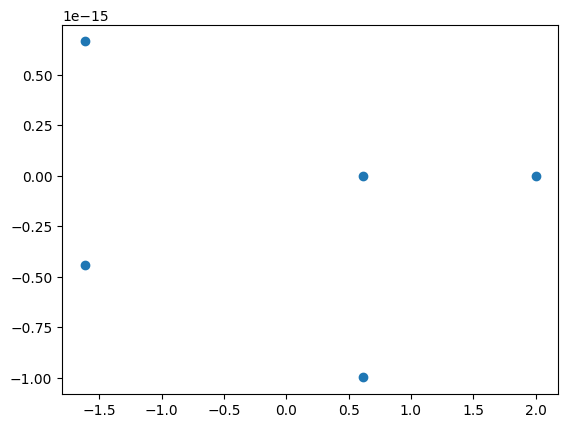

In [28]:
plt.scatter(np.real(lookup), np.imag(lookup))

In [22]:
sum(lookup)

np.complex128(8.881784197001252e-16-7.771561172376096e-16j)

In [23]:
np.abs(np.array(lookup))

array([2.        , 0.61803399, 0.61803399, 1.61803399, 1.61803399])

In [13]:
[v / r for v, r in zip([choose_ij(roots, 0, i) for i in range (0, 5)], roots)]

[np.complex128(-0.8090169943749481-0.5877852522924731j),
 np.complex128(0.3090169943749464+0.9510565162951544j),
 np.complex128(0.9999999999999997+2.639712105276675e-16j),
 np.complex128(0.30901699437494784-0.951056516295153j),
 np.complex128(-0.8090169943749477+0.5877852522924727j)]

In [18]:
def choose_both(vals, i, j):
    return choose_ij(vals, i, j) + choose_ij(vals, j, i)

In [48]:
def f_first(vals):
    prod = np.complex128(1)
    for j in range(len(vals)):
        for k in range(j+1, len(vals)):
            prod *= choose_both(vals, j, k)

    return prod

In [55]:
def f_second(vals):
    A = np.zeros([len(vals), len(vals)], dtype=np.complex128)
    for j in range(len(vals)):
        for k in range(len(vals)):
            if j == k:
                continue
            A[j,k] = -1 * choose_ij(vals, j, k) / choose_both(vals, j, k)

    for i in range(len(vals)):
        # check if this is row or col sum
        A[i, i] = -1 * A[i, :].sum()

    return np.linalg.det(A[:-1, :-1])

In [56]:
def f(vals):
    return f_first(vals) * f_second(vals)

In [57]:
def count_cycles(n, m):
    roots = np.roots([1] + [0]*(m-1) + [-1])

    s = np.complex128()

    for mult, x in combs_with_multiplicity(roots, n-1):
        s += mult*f(x + [np.complex128(1)])
    
    return s / m ** (n-1)

In [58]:
# Example usage:
count_cycles(7, 5)

np.complex128(1015440.0000000041+1.4495849609374998e-10j)

# Jack Offset code

In [ ]:
# So - our calculation has given us both the constant term - and also the terms where the exponents are all in {0, -6, 6}
# The exponents of the x_i are calculating the "net out degree". So note that the only vertex that can have net out degree is the root vertex of our tree - v_n
# Note also that the total degree of each term is zero. So therefore these terms must all be of the form x_i^6*x_n*-6 - i!= n
# We could try and calculate this term directly (and multiply by n-1 for the n-1 choices for i at the end)
# Wlog take i = n-1
# We want to force our graph to have directed edges E_n-1,i and E_i,n. 
# So we can take an adjusted f_first with all these coefficients
# Then in our matrix we could fill things as normal but put a zero if E_i,n-1 or E_n,i is in the tree, and put a 1 where E_n-1,i or E_i,n in the tree
# This also lets us factor x_i, x_n out of our formula. Taking these two out both adds and removes 1 from each degree putting us back where we started

In [137]:
def f_second_mod(vals):
    n = len(vals)+2
    A = np.zeros([n, n], dtype=np.complex128)
    for j in range(len(vals)):
        for k in range(len(vals)):
            if j == k:
                continue
            A[j,k] = -1 * choose_ij(vals, j, k) / choose_both(vals, j, k)

    for i in range(n):
        # if i != n-1:
        A[i, n-1] = -1
        A[n-1, i] = 0

        if i != n-2:
            A[i, n-2] = 0
            A[n-2, i] = -1

    for i in range(len(vals)+2):
        A[i, i] = -1 * A[i, :].sum()

    # return A

    return np.linalg.det(A[:-1, :-1])

In [141]:
w = roots[0]
w2 = roots[1]

In [142]:
f_second_mod([1, w, w, w, w])

np.complex128(1220.9999999999998-109.11920087683887j)

In [143]:
f_second_mod([w, w2, w2, w2, w2])

np.complex128(1220.9999999999995-109.11920087683924j)

In [132]:
def jack_offset_f(vals):
    return f_first(vals) * f_second_mod(vals)

In [133]:
def calc_jack_offset(n, m):
    roots = np.roots([1] + [0]*(m-1) + [-1])
    
    s = np.complex128()
    
    for x in itertools.product(roots, repeat=n-3):
        s += jack_offset_f(x + (np.complex128(1),))
    
    return (n-1) * s / m ** (n-3)

In [134]:
# example usage - note only works for n%4=-1
count_cycles(7, 3) - calc_jack_offset(7, 3)

np.complex128(1015439.999999999-3.768726467922718e-11j)

In [135]:
calc_jack_offset(7, 3)

np.complex128(156383.9999999999+0j)

In [136]:
156384 / 26064

6.0

# Jack Vertex Fix

In [92]:
def f_first_restricted(vals, forced_values: dict[dict[bool]]):
    prod = np.complex128(1)
    for j in range(len(vals)):
        for k in range(j+1, len(vals)):
            if j in forced_values or k in forced_values:
                continue
            else:
                prod *= choose_both(vals, j, k)

    for f_vals in forced_values.values():
        for second_vertex, points_to_second in f_vals.items():
            if points_to_second:
                prod /= vals[second_vertex]
            else:
                prod *= vals[second_vertex]

    return prod

In [32]:
def f_second_restricted(vals, forced_values: dict[dict[bool]]):
    n = len(vals)
    A = np.zeros([n, n], dtype=np.complex128)
    for j in range(len(vals)):
        for k in range(len(vals)):
            if j == k:
                continue

            if j in forced_values or k in forced_values:
                continue

            A[j,k] = -1 * choose_ij(vals, j, k) / choose_both(vals, j, k)

    for first_vertex, dirs in forced_values.items():
        for second_vertex, points_to_second in dirs.items():
            A[first_vertex, second_vertex] = -int(points_to_second)
            A[second_vertex, first_vertex] = -int(not points_to_second)
                
    for i in range(n):
        # check if this is row or col sum
        A[i, i] = -1 * A[i, :].sum()

    # return A
    
    return np.linalg.det(A[:-1, :-1])

In [33]:
m = 3
roots = np.roots([1] + [0]*(m-1) + [-1])
w = roots[1]

In [34]:
f_second_restricted([w, w, w*w, w*w, 1], {0: {1: True, 2: True, 3:False, 4:False}})

np.complex128(-2.2499999999999916-3.8971143170299682j)

In [35]:
f_second_restricted([w*w, w, w, w*w, 1], {0: {1: True, 2: True, 3:False, 4:False}})

np.complex128(6.538073133704127e-15+6.928203230275519j)

In [94]:
def f_restricted(vals, forced_values: dict[dict[bool]]):
    return f_first_restricted(vals, forced_values) * f_second_restricted(vals, forced_values)

In [98]:
def calculate_efficient(n, m, forcings):
    # n = 7
    # m = 5
    roots = np.roots([1] + [0]*(m-1) + [-1])
    
    # hardcodes = 
    
    s = np.complex128()
    
    for x in itertools.product(roots, repeat=n-len(forcings)-1):
        s += f_restricted((1,) + x + (np.complex128(1),), forcings)
    
    return s * math.comb(n-1, (n-1)//2) / m ** (n-2)

In [99]:
calculate_efficient(7, 5, {0: {1: True, 2: True, 3:True, 4:False, 5:False, 6:False}})

np.complex128(1015440.000000001-2.9802322387695314e-12j)

# Messing with multiple ms

In [97]:
# This is much faster in python - we're summing over 5 * 3^5 combinations. However after the necklace considerations:
# ./nnecklaces 5 7 -> 66
# ./nnecklaces 3 7 -> 12
# So we'd be going from 66 necklaces to 5 * 12 = 60 necklace combinations.
# Might be worth - but the Jack Offset achieves the same but better

n = 7
m1 = 3
m2 = 5

roots1 = np.roots([1] + [0]*(m1-1) + [-1])
roots2 = np.roots([1] + [0]*(m2-1) + [-1])

s = np.complex128()

for x in itertools.product(roots1, repeat=n-2):
    for r2 in roots2:
        s += f(x + (1, r2))
    
s / m2 / m1 ** (n-2)

np.complex128(1015440.0000000001+0j)

# Nonsense musings

In [ ]:
# Ok - let's play the K9 game
# We're supposed to use M=5 
# Suppose we use M=3...
# We pick up powers of X^6
# Let's say for now we sum the final root over m=5...
# That means we can't have any powers of 6 in the root vertex
# Every vertex needs to have at least one out node
# So let's look at the in counts... Say vertex 1 has a power of -6... That means exactly 7 ins and 1 out
# The out has to be going to the root vertex...
# So this is actually super constrained